# NLP Text Classification And Recommendation System 

In [2]:
# import all necessary libraries
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer 
import string, re
from gensim.utils import simple_preprocess
import gensim
from gensim import corpora,models
from sklearn.metrics import pairwise_distances
import pickle
import spacy
from tqdm import tqdm

# show up to 300 results in both rows and columns 
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

## Preprocessing & Cleaning

In [17]:
# load the data
df1=pd.read_csv('2019_EN_catalog_-_Jul_to_Sep.csv',encoding= 'unicode_escape')
df2=pd.read_csv('2019_EN_catalog_-_Oct_to_Dec.csv',encoding= 'unicode_escape')

In [18]:
# concat two dataframe together and reset index to ID
df=pd.concat([df1,df2], axis=0).reset_index().rename(columns={'index': 'ID'})
df.head()

,ID,Product Title,Product Author,Product Narrator,Product Publisher Name,Product Primary Category,Product Primary Sub Category,Product Long Description
0,0,'The Loudest Voice': Wondering About THAT Open...,Joyce Chen,"""""",Cosmopolitan,NaN,NaN,<p>This should help. </p>
1,1,[Clone] A Coldness in the Blood: The New Dracu...,Fred Saberhagen,Robin Bloodworth,Audible Studios,Sci-Fi & Fantasy,Fantasy: Paranormal,<p>The Bram Stoker Award-Winning saga continue...
2,2,[Clone] A Matter of Policy: An Amy Brewster My...,Sam Merwin Jr.,Janelle Bigham,Wordwooze Publishing,Mysteries & Thrillers,Suspense,<p><i>A Matter of Policy </i>is an enthralling...
3,3,[Clone] Any Way the Wind Blows: A Novel (Unabr...,E. Lynn Harris,"Dominic Hoffman, Bahni Turpin, Mirron Willis",Random House Audio,Fiction,Contemporary,"<p>At the end of <i>Not a Day Goes By</i>, the..."
4,4,[Clone] Jack & Jill (Unabridged),James Patterson,"Ron Butler, Maxwell Hamilton",Hachette Audio,Mysteries & Thrillers,Psychological,<p><b>Available as an unabridged audiobook for...


In [19]:
# check the original data shape
df.shape

(41794, 8)

In [20]:
# check if there is any missing value
df.isna().sum()

ID                                 0
Product Title                      0
Product Author                     0
Product Narrator                   0
Product Publisher Name             0
Product Primary Category        7087
Product Primary Sub Category    7087
Product Long Description        5396
dtype: int64

In [21]:
# drop nan values in product long description
df.dropna(subset = ['Product Long Description'], inplace = True)

In [22]:
# drop nan values in product primary category
df.dropna(subset = ['Product Primary Category'], inplace = True)

In [23]:
# drop unnecessary columns
df.drop(columns=[ 'Product Narrator', 'Product Publisher Name', 'Product Primary Sub Category'], inplace=True)

In [24]:
# remove unnecessary genres in product primary category
df=df[(df['Product Primary Category'] != 'Parents & Family') & (df['Product Primary Category'] != 'Products') & (df['Product Primary Category'] != 'Professionals') & (df['Product Primary Category'] != 'Students') & (df['Product Primary Category'] != 'Merchandising ') & (df['Product Primary Category'] != 'Short Stories') & (df['Product Primary Category'] != 'VERIFICATION NODES1')& (df['Product Primary Category'] != 'Merchandising')]                                                                                                                                                                                    

In [25]:
# check how the data looks like now
df.head(5)

,ID,Product Title,Product Author,Product Primary Category,Product Long Description
1,1,[Clone] A Coldness in the Blood: The New Dracu...,Fred Saberhagen,Sci-Fi & Fantasy,<p>The Bram Stoker Award-Winning saga continue...
2,2,[Clone] A Matter of Policy: An Amy Brewster My...,Sam Merwin Jr.,Mysteries & Thrillers,<p><i>A Matter of Policy </i>is an enthralling...
3,3,[Clone] Any Way the Wind Blows: A Novel (Unabr...,E. Lynn Harris,Fiction,"<p>At the end of <i>Not a Day Goes By</i>, the..."
4,4,[Clone] Jack & Jill (Unabridged),James Patterson,Mysteries & Thrillers,<p><b>Available as an unabridged audiobook for...
5,5,[Clone] The Book of Mormon (Unabridged),Joseph Smith - translator,Religion & Spirituality,<p>The Book of Mormon is a sacred text of the ...


In [26]:
# check the new shape
df.shape

(34702, 5)

In [27]:
# sort book name alphabetically
df.sort_values("Product Title", inplace = True) 

In [28]:
# remove duplicate books
df.drop_duplicates(subset ="Product Title", keep = False, inplace = True) 

In [31]:
# check the new df
df.head()

,ID,Product Title,Product Author,Product Primary Category,Product Long Description
41303,18976,"# ""No Room in the Inn?"": The Fiery Trials of L...",Brad Wyrick,Religion & Spirituality,"<p><i># ""No Room in the Inn?""</i> will take us..."
22327,0,#1 Lie (Unabridged),T. Gephart,Romance,<p>Working in Hollywood meant Jessica Dawson w...
22328,1,#1 Love (Unabridged),T. Gephart,Romance,<p>It was easy to fall in love with a Larsson ...
22329,2,#1 Muse (Unabridged),T. Gephart,Romance,<p>Landing a writing gig in Hollywood was just...
33948,11621,#1 in Customer Service: The Complete Adventure...,Larry Correia,Sci-Fi & Fantasy,"<p>No alien menace is too menacing, no galacti..."


In [32]:
# check the new shape
df.shape

(34330, 5)

In [33]:
# check if there is still missing values
df.isna().sum()

ID                          0
Product Title               0
Product Author              0
Product Primary Category    0
Product Long Description    0
dtype: int64

In [51]:
# set product long description to a short variable name
data = df['Product Long Description']

In [36]:
# create a set of stop words list
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '-', '–', '—','li','/li',"n't",
            'p','/p','/i','b','/b',"'s",'br','>','<','i','/','A','\x92','\x92s','\x92ll','.com','\x97',
           '\x97s','\x93','\x94','']
sw_set = set(sw_list)

In [37]:
# create a function to extract only nouns in nltk tokenize
def noun_article(article):
    nouns = nltk.word_tokenize(article)
    tagged = nltk.pos_tag(nouns)
    length = len(tagged) - 1
    noun_only = list()
    for i in range(0, length):
        log = (tagged [i][1][0] == 'N')
        if log == True:
            noun_only.append(tagged [i][0])
    stopwords_removed = [n.lower() for n in noun_only if n.lower() not in sw_set]
    return stopwords_removed

In [ ]:
# applying the above functions to our data 
processed_data = list(map(noun_article, data))

In [ ]:
# pickle the processed data
file = open('processed_data.p', 'wb')
pickle.dump(processed_data,file)
file.close()

In [38]:
# load pickled processed data
file = open('processed_data.p', 'rb')
processed_data = pickle.load(file)
file.close()
processed_data[:1]

[['room',
  'inn',
  'humanity',
  'garden',
  'eden',
  'believers',
  'crown-wearers',
  'heaven',
  'god\x92s',
  'word',
  'trials',
  'temptations',
  'god',
  'kingdom',
  'reward',
  'system.',
  'trials',
  'life',
  'faith',
  'character',
  'goal',
  'foremost',
  'trials',
  'way',
  'god\x92s',
  'plan',
  'purpose',
  'lives',
  'satan\x92s',
  'weapon',
  'ignorance',
  'god\x92s',
  'word',
  'scriptural',
  'truth',
  'threshold',
  'decision',
  'life',
  'promises',
  'principles',
  'provisions',
  'will.',
  'scripture',
  'spirit',
  'fellowship',
  'suffering',
  'image',
  'power',
  'resurrection',
  'path',
  'life',
  'jesus',
  'word',
  'fact',
  'word.',
  'furthermore',
  'room',
  'inn',
  'jesus',
  'didn\x92t',
  'purpose',
  'remember',
  'innkeeper',
  'heart',
  'vacancy',
  'sign.']]

In [39]:
# check the total count of words in processed data
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

87859

In [48]:
# join strings in processed data to one long string
new_processed_data = [' '.join(w) for w in processed_data]
new_processed_data[:1]

['room inn humanity garden eden believers crown-wearers heaven god\x92s word trials temptations god kingdom reward system. trials life faith character goal foremost trials way god\x92s plan purpose lives satan\x92s weapon ignorance god\x92s word scriptural truth threshold decision life promises principles provisions will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didn\x92t purpose remember innkeeper heart vacancy sign.']

In [92]:
# create a function to exclude all html format
def article(text):
    text = re.sub(r'\<[\w/]+\>', '', text)
    text = text.replace("</p>",'')
    text = text.replace("<p>",'')
    text = text.replace("</ul>",'')
    text = text.replace("<ul>",'')
    text = text.replace("</li>",'')
    text = text.replace("<li>",'')
    text = text.replace("</i>",'')
    text = text.replace("<i>",'')
    text = text.replace("</b>",'')
    text = text.replace("<b>",'')
    text = text.replace("</>",'')
    text = text.replace("\'s",'')
    text = text.replace("\'t",'')
    text = text.replace("\'ll",'')
    text = text.replace("\x92",'')
    text = text.replace("\x92s",'')
    text = text.replace("\x93",'')
    text = text.replace("\x94",'')
    text = text.replace("\x91",'')
    text = text.replace("\x97",'')
    text = text.replace("\x85",'')
    text = text.replace("\xa0",'')
    text = text.replace("/ul",'')
    text = text.replace("(Unabridged)",'')
    text = text.replace("#",'')
    text = text.replace("[Clone]",'')
    return text

In [93]:
# apply the above function to both book title and book description
new_title_list = list(map(article,df['Product Title']))
new_discription_list = list(map(article,df['Product Long Description']))

In [94]:
# turn both title list and discription list to dataframe
new_title = pd.DataFrame(new_title_list)
new_diccription = pd.DataFrame(new_discription_list)

In [95]:
# replace both original product title and product long discription by new cleaned title and description
df['Product Title'] = new_title
df['Product Long Description'] = new_diccription

In [96]:
# check the final df
df.head()

,ID,Product Title,Product Author,Product Primary Category,Product Long Description,word_count
0,18976,"""No Room in the Inn?"": The Fiery Trials of Li...",Brad Wyrick,Religion & Spirituality,"""No Room in the Inn?"" will take us from human...",227
1,0,1 Lie,T. Gephart,Romance,Working in Hollywood meant Jessica Dawson was ...,240
2,1,1 Love,T. Gephart,Romance,It was easy to fall in love with a Larsson - s...,196
3,2,1 Muse,T. Gephart,Romance,Landing a writing gig in Hollywood was just as...,327
4,11621,1 in Customer Service: The Complete Adventures...,Larry Correia,Sci-Fi & Fantasy,"No alien menace is too menacing, no galactic r...",280


In [97]:
# pickle the final dataframe
file = open('df.p', 'wb')
pickle.dump(df,file)
file.close()

In [98]:
# load pickled final dataframe
file = open('df.p', 'rb')
df = pickle.load(file)
file.close()
df.head()

,ID,Product Title,Product Author,Product Primary Category,Product Long Description,word_count
0,18976,"""No Room in the Inn?"": The Fiery Trials of Li...",Brad Wyrick,Religion & Spirituality,"""No Room in the Inn?"" will take us from human...",227
1,0,1 Lie,T. Gephart,Romance,Working in Hollywood meant Jessica Dawson was ...,240
2,1,1 Love,T. Gephart,Romance,It was easy to fall in love with a Larsson - s...,196
3,2,1 Muse,T. Gephart,Romance,Landing a writing gig in Hollywood was just as...,327
4,11621,1 in Customer Service: The Complete Adventures...,Larry Correia,Sci-Fi & Fantasy,"No alien menace is too menacing, no galactic r...",280


### lemmatization

In [99]:
# apply noun only function on processed data
final_noun_list = list(map(article, new_processed_data))

In [100]:
# prepare to lemmatize
lemmatizer = WordNetLemmatizer() 

In [101]:
# creating a list with all lemmatized outputs in final noun list
lemmatized_output = []
for listy in final_noun_list:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy.split()])
    lemmatized_output.append(lemmed)

In [102]:
# set the lemmatized outputs to a variable name 
final_noun_list_lemmatizd = lemmatized_output

In [103]:
# pickle the lemmatized outputs
file = open('final_noun_list_lemmatizd.p', 'wb')
pickle.dump(final_noun_list_lemmatizd,file)
file.close()

In [104]:
# load pickled lemmatized outputs
file = open('final_noun_list_lemmatizd.p', 'rb')
final_noun_list_lemmatizd = pickle.load(file)
file.close()
final_noun_list_lemmatizd[:1]

['room inn humanity garden eden believer crown-wearers heaven god word trial temptation god kingdom reward system. trial life faith character goal foremost trial way god plan purpose life satan weapon ignorance god word scriptural truth threshold decision life promise principle provision will. scripture spirit fellowship suffering image power resurrection path life jesus word fact word. furthermore room inn jesus didnt purpose remember innkeeper heart vacancy sign.']

## EDA

In [105]:
# set product primary category values to a short variable name 
labels = df['Product Primary Category'].values

In [106]:
# check the sorted value counts in product primary category
df['Product Primary Category'].value_counts().sort_values(ascending=False)

Self Development           4782
Romance                    4501
Newspapers & Magazines     3290
Mysteries & Thrillers      2693
Sci-Fi & Fantasy           2604
Fiction                    1950
Teens                      1785
Religion & Spirituality    1509
Science & Technology       1409
Business                   1380
Kids                       1213
Nonfiction                 1117
Erotica & Sexuality         961
Bios & Memoirs              954
History                     902
Health & Fitness            752
Sports                      527
Arts & Entertainment        411
Nostalgia Radio             338
Classics                    337
Language Instruction        224
Drama & Poetry              204
Travel & Adventure          163
Comedy                      121
Radio & TV                  109
Live Events                  61
Kids & Young Adults          33
Name: Product Primary Category, dtype: int64

Text(0.5, 1.0, 'Distribution Of Genres')

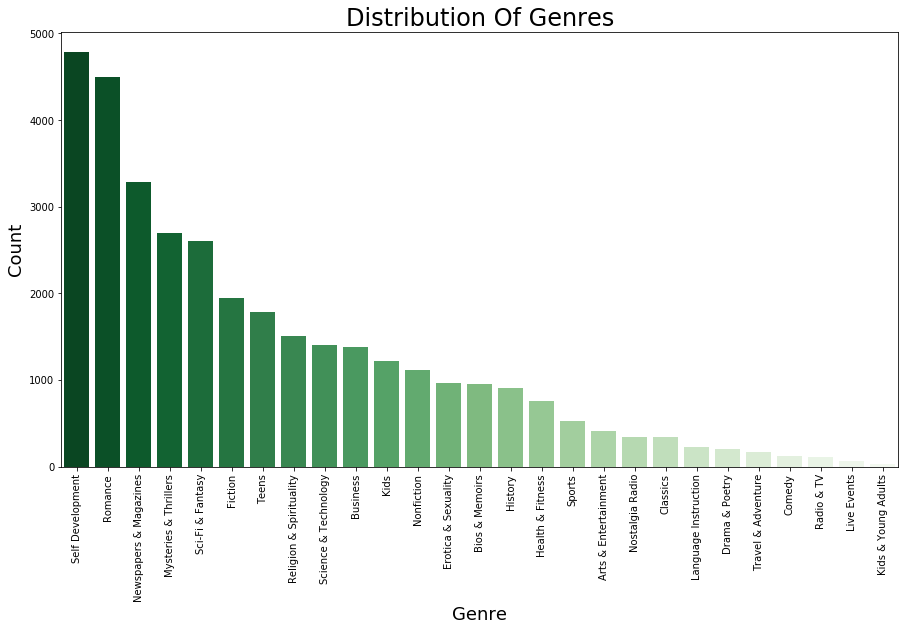

In [107]:
# plot distribution of genres in descending
plt.figure(figsize = (15,8))
g=sns.countplot(x =labels, palette="Greens_r",order = df['Product Primary Category'].value_counts().index)
g.set(xticklabels=['Self Development', 'Romance', 'Newspapers & Magazines','Mysteries & Thrillers','Sci-Fi & Fantasy','Fiction','Teens','Religion & Spirituality','Science & Technology','Business','Kids','Nonfiction','Erotica & Sexuality','Bios & Memoirs','History','Health & Fitness','Sports','Arts & Entertainment','Nostalgia Radio','Classics','Language Instruction','Drama & Poetry','Travel & Adventure','Comedy','Radio & TV','Live Events','Kids & Young Adults'])
plt.xticks(rotation=90)
plt.xlabel('Genre',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.title('Distribution Of Genres', fontsize=24)

In [108]:
# calculate word counts in product long description
word_count = df['Product Long Description'].apply(lambda x:len(x.split()))
print('mean:', word_count.mean())
print('25 quantile:', word_count.quantile(0.25))
print('75 quantile:', word_count.quantile(0.75))

mean: 157.47838625109233
25 quantile: 85.0
75 quantile: 225.0


Text(0.5, 1.0, 'Average word count in book discription ')

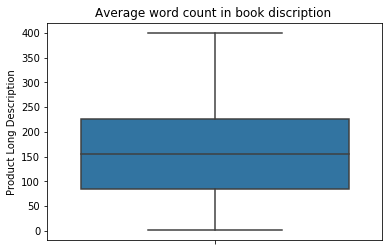

In [109]:
# plot the above numbers
sns.boxplot(y=word_count, showfliers=False)
plt.title('Average word count in book discription ')

In [110]:
# create new word count column in df
df['word_count'] = word_count
df.head()

,ID,Product Title,Product Author,Product Primary Category,Product Long Description,word_count
0,18976,"""No Room in the Inn?"": The Fiery Trials of Li...",Brad Wyrick,Religion & Spirituality,"""No Room in the Inn?"" will take us from human...",227
1,0,1 Lie,T. Gephart,Romance,Working in Hollywood meant Jessica Dawson was ...,233
2,1,1 Love,T. Gephart,Romance,It was easy to fall in love with a Larsson - s...,196
3,2,1 Muse,T. Gephart,Romance,Landing a writing gig in Hollywood was just as...,318
4,11621,1 in Customer Service: The Complete Adventures...,Larry Correia,Sci-Fi & Fantasy,"No alien menace is too menacing, no galactic r...",279


Text(0, 0.5, 'word count')

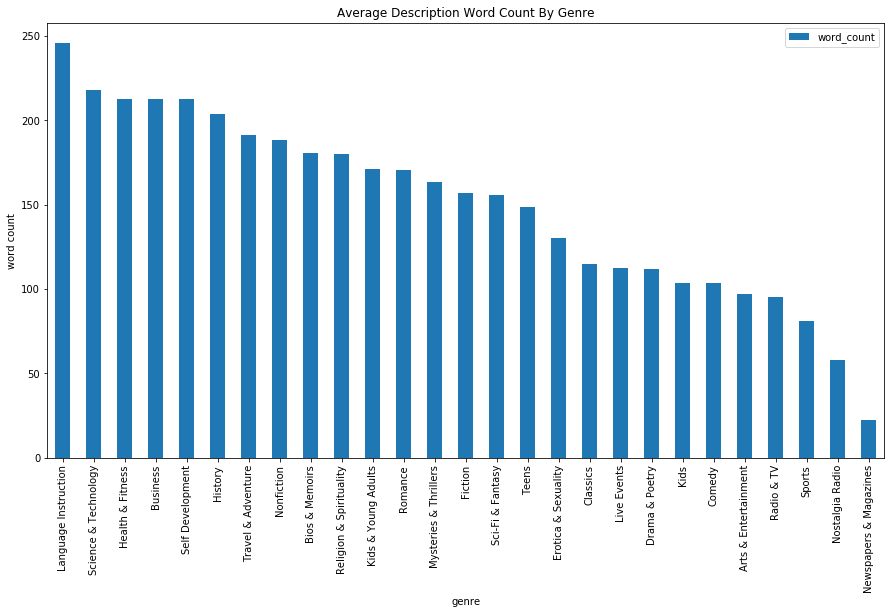

In [111]:
# group average word count by genre and visualize it in descending
a=df.groupby(['Product Primary Category'])['word_count'].mean()
ax = pd.DataFrame(a.sort_values(ascending=False)).plot(kind='bar',figsize =(15,8),use_index=bool,title='Average Description Word Count By Genre')
ax.set_xlabel('genre')
ax.set_ylabel('word count')

In [ ]:
# make the above graph to a dataframe 
pd.DataFrame(a.sort_values(ascending=False)).head()

In [112]:
# randomly select 1000 observations in df
eda = df.sample(n=1000, replace=False, random_state=10)

In [122]:
# join strings in smapledf product long description to one long string
total_description=[]
for i in eda['Product Long Description']:
    total_description.append(i)
    list_to_str = ' '.join([str(elem) for elem in total_description])
list_to_str[:44]                   

'Do you want to learn about dialysis recipes?'

In [123]:
# tokenize the above string
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
tokenized_review = tokenizer.tokenize(list_to_str)

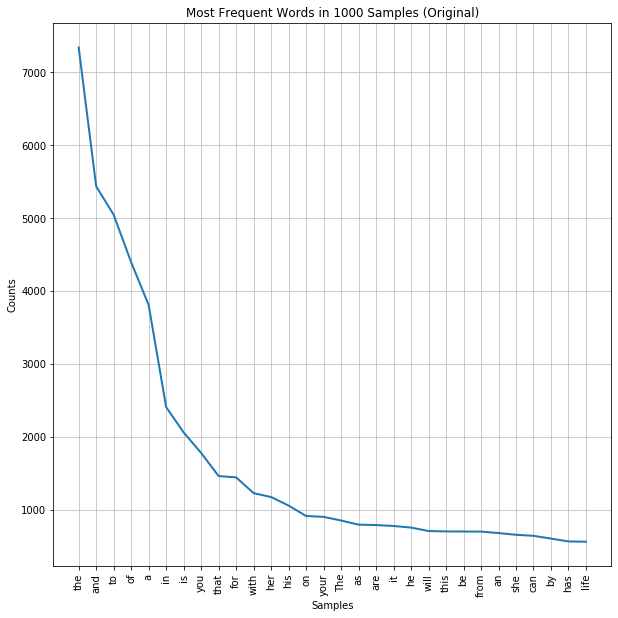

In [130]:
# plot the 30 most frequent words in sampledf product long description
fdist = FreqDist(tokenized_review)
plt.figure(figsize=(10,10))
plt.title('Most Frequent Words in 1000 Samples (Original)')
fdist.plot(30)

In [125]:
# apply noun only function on sampledf product long description
noun_list = noun_article(list_to_str)

In [126]:
# join strings in above list to one long string
list_to_str2 = ' '.join([str(elem) for elem in noun_list])
list_to_str2[:17]

'dialysis recipes '

In [127]:
# tokenize the above string
tokenized_review2 = tokenizer.tokenize(list_to_str2)

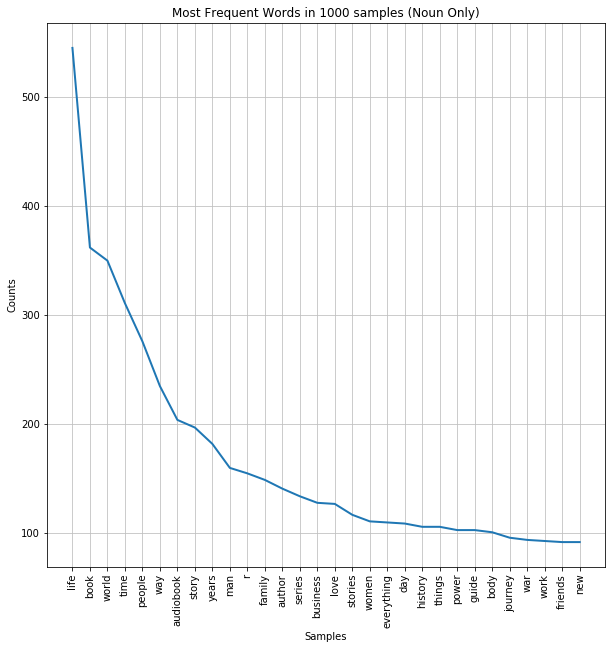

In [129]:
# plot the 30 most frequent noun only words in sampledf product long description
fdist2 = FreqDist(tokenized_review2)
plt.figure(figsize=(10,10))
plt.title('Most Frequent Words in 1000 samples (Noun Only)')
fdist2.plot(30)

### Most Frequent Words

In [131]:
# Try to compare fiction vs nonfiction
df_freq_ficiton = df[df['Product Primary Category']=='Fiction']
df_freq_nonficiton = df[df['Product Primary Category']=='Nonfiction']

In [133]:
# get discriptions from fiction and nonfiction
data_fiction = df_freq_ficiton['Product Long Description']
data_nonfiction = df_freq_nonficiton['Product Long Description']

In [134]:
# apply noun only function to fiction and nonfiction description
pros_fiction = list(map(noun_article, data_fiction))
pros_nonfiction = list(map(noun_article, data_nonfiction))

In [135]:
# check the total count of words in fiction and nonfiction
total_vocab_fiction = set()
total_vocab_nonfiction = set()
for comment in pros_fiction:
    total_vocab_fiction.update(comment)
for comment in pros_nonfiction:
    total_vocab_nonfiction.update(comment)
print('total vocabulary in fiction:',len(total_vocab_fiction))
print('total vocabulary in nonfiction:',len(total_vocab_nonfiction))

total vocabulary in fiction: 19643
total vocabulary in nonfiction: 14906


In [139]:
# check sample words in fiction
print(pros_fiction[:1])

[['climate', 'change', 'water', 'crisis', 'china', 'prairie', 'provinces', 'river', 'water', 'hudson', 'bay', 'beijing', 'passage', 'year-round', 'story', 'insights', 'canada', 'water', 'resources', 'geography', 'history.environmentalists', 'north', 'canada', 'water', 'resources', 'jeremiah', 'coffey', 'us', 'presidentis', 'chinese', 'canada', 'columbia', 'united', 'states', 'drought', 'americans', 'water', 'california', 'british', 'columbia', 'rivers', 'us', 'state', 'department', 'cia', 'tactics', 'lee', 'girard', 'asset', 'field.the', 'green', 'party', 'power', 'months', 'sheila', 'thompson', 'prime', 'minister', 'canada', 'chinese', 'occupation', 'meddling', 'minister', 'national', 'defence', "'rolly", "o'brien", 'salty', 'newfoundlander', 'korean', 'chief', 'defence', 'staff', 'general', 'robert', 'fraser', 'husband', 'to-be', 'staff', 'stuart', 'mcgee', 'everything', 'plan', 'chinese', 'remembrance', 'day.the', 'british', 'prime', 'minister', 'post', 'brexit', 'woes', 'collapse',

In [140]:
# check sample words in nonfiction
print(pros_nonfiction[:1])

[['milestone', 'crime', 'hall-mills', 'case', 'new', 'brunswick', 'new', 'jersey', 'decade', 'killer', 'case', 'aficionados.a', 'bon', 'vivant', 'episcopal', 'minister', 'soprano', 'choir', 'wife', 'brother', 'maid', 'snooping', 'congregants', 'bumbling', 'detectives', 'denouement', 'trial', 'americas', 'jazz', 'age', 'likes', 'damon', 'runyon', 'dorothy', 'dix', 'james', 'thurber', 'testimony', 'witness', 'veracity', 'farmer', 'tabloids', 'pig', 'woman', 'almost', 'everyone', 'mystery', 'secret', 'one', 'years', 'audibles', 'request', 'business', 'crime', 'journalist', 'bryan', 'burrough', 'case', 'records', 'time', 'narration', 'texas', 'accent', 'immediacy', 'intimacy', 'new', 'jersey', 'crime', 'listeners', 'reconstruction', 'double-murderand', 'prosecution', 'media', 'circus', 'day']]


In [141]:
# preprocess the data before calculating frequency 
flat_fiction = [item for sublist in pros_fiction for item in sublist]
flat_nonfiction = [item for sublist in pros_nonfiction for item in sublist]

In [143]:
# apply freqent funtions to above lists
fiction_freq = FreqDist(flat_fiction)
nonfiction_freq = FreqDist(flat_nonfiction)

In [144]:
# check top 20 fiction words
fiction_freq.most_common(20)

[('life', 1206),
 ('story', 763),
 ('family', 736),
 ('man', 637),
 ('world', 630),
 ('love', 514),
 ('time', 507),
 ('stories', 477),
 ('novel', 459),
 ('book', 432),
 ('author', 426),
 ('years', 398),
 ('woman', 368),
 ('war', 362),
 ('home', 357),
 ('way', 341),
 ('new', 318),
 ('father', 315),
 ('mother', 306),
 ('town', 286)]

In [145]:
# check top 20 nonfiction words
nonfiction_freq.most_common(20)

[('book', 601),
 ('world', 491),
 ('people', 417),
 ('history', 402),
 ('life', 386),
 ('story', 351),
 ('women', 311),
 ('years', 307),
 ('time', 285),
 ('america', 275),
 ('trump', 239),
 ('new', 237),
 ('audiobook', 232),
 ('author', 231),
 ('stories', 213),
 ('power', 203),
 ('way', 201),
 ('war', 172),
 ('states', 171),
 ('work', 169)]

### Normalized word frequencies

In [147]:
# normalize top 20 fiction words to percentage
fiction_total_word_count = sum(fiction_freq.values())
fiction_top_20 = fiction_freq.most_common(20)
print("Word \t\t Normalized Frequency")
print()
for word in fiction_top_20:
    normalized_frequency = word[1]/fiction_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

life 		 0.01243
story 		 0.007867
family 		 0.007588
man 		 0.006568
world 		 0.006495
love 		 0.005299
time 		 0.005227
stories 		 0.004918
novel 		 0.004732
book 		 0.004454
author 		 0.004392
years 		 0.004103
woman 		 0.003794
war 		 0.003732
home 		 0.003681
way 		 0.003516
new 		 0.003279
father 		 0.003248
mother 		 0.003155
town 		 0.002949


In [148]:
# normalize top 20 nonfiction words to percentage
nonfiction_total_word_count = sum(nonfiction_freq.values())
nonfiction_top_20 = nonfiction_freq.most_common(20)
print("Word \t\t Normalized Frequency")
print()
for word in nonfiction_top_20:
    normalized_frequency = word[1]/nonfiction_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

book 		 0.008764
world 		 0.00716
people 		 0.006081
history 		 0.005862
life 		 0.005629
story 		 0.005119
women 		 0.004535
years 		 0.004477
time 		 0.004156
america 		 0.00401
trump 		 0.003485
new 		 0.003456
audiobook 		 0.003383
author 		 0.003369
stories 		 0.003106
power 		 0.00296
way 		 0.002931
war 		 0.002508
states 		 0.002494
work 		 0.002465


### visualization

In [150]:
# create counts of fiction and nonfiction with values and words
fiction_bar_counts = [x[1] for x in fiction_freq.most_common(20)]
fiction_bar_words = [x[0] for x in fiction_freq.most_common(20)]
nonfiction_bar_counts = [x[1] for x in nonfiction_freq.most_common(20)]
nonfiction_bar_words = [x[0] for x in nonfiction_freq.most_common(20)]

In [151]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

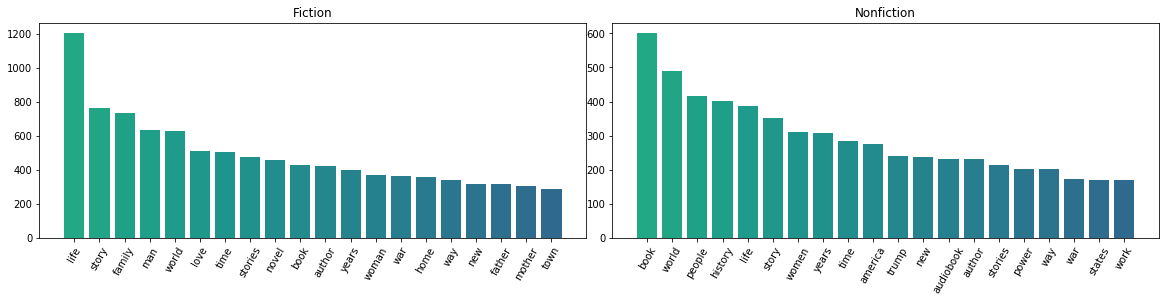

In [153]:
# visualize the result in descending
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

ax.bar(fiction_bar_words, fiction_bar_counts, color=color)

ax2.bar(nonfiction_bar_words, nonfiction_bar_counts, color=color )

ax.title.set_text('Fiction')
ax2.title.set_text('Nonfiction')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

plt.show()

### Word Clouds

In [155]:
# set fiction and nonfiction words to dictionary
fiction_dictionary = dict(zip(fiction_bar_words, fiction_bar_counts))
nonfiction_dictionary = dict(zip(nonfiction_bar_words, nonfiction_bar_counts))

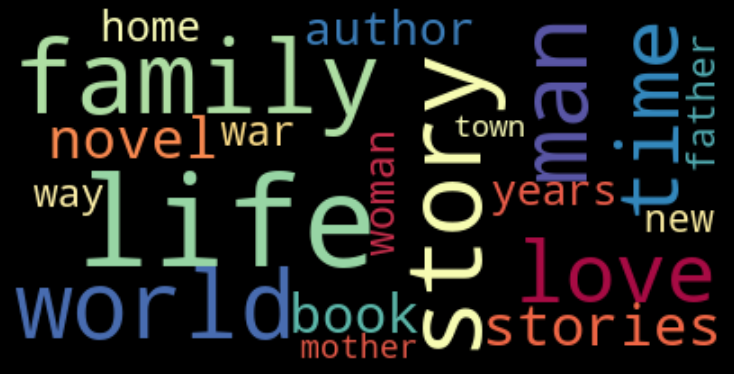

In [156]:
# create the fiction word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(fiction_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

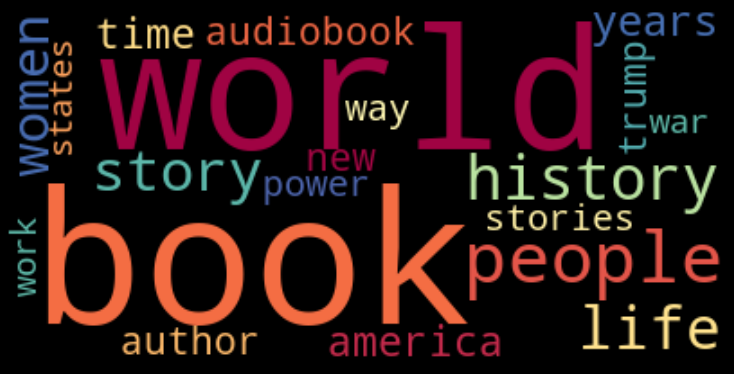

In [158]:
# Create the nonfiction word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(nonfiction_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

##  Recommendation System

### Gensim Corpus Model

In [ ]:
final_noun_list_lemmatizd[:1]

In [ ]:
new_final_noun_list_lemmatizd = [''.join(w) for w in final_noun_list_lemmatizd]

In [ ]:
final_noun_list_lemmatizd[:1]

In [ ]:
def preprocess_body(text):
    simple_text = simple_preprocess(text)
    text_out = [ word for word in simple_text ]
    return text_out

In [ ]:
list_of_word_token = list(map(preprocess_body, final_noun_list_lemmatizd))

In [ ]:
id2word = corpora.Dictionary(list_of_word_token)
id2word.filter_extremes(no_below=30,no_above=0.5,keep_n=10000)
texts = list_of_word_token
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
print('word count in id2word:',len(id2word))
print('word coint in texts:',len(texts))

In [ ]:
corpusdf=pd.DataFrame(gensim.matutils.corpus2dense(corpus,num_terms=5273,num_docs=34330)).T

In [ ]:
corpusdf.columns=id2word.token2id

In [ ]:
corpusdf['book_title']=df['Product Title']

In [ ]:
file = open('corpusdf.p', 'wb')
pickle.dump(corpusdf,file)
file.close()

In [ ]:
file = open('corpusdf.p', 'rb')
corpusdf = pickle.load(file)
file.close()
corpusdf.head()

### Cosine Similarity

In [ ]:
cosine_sim = 1-pairwise_distances(corpusdf.drop(columns='book_title'), metric='cosine',n_jobs=-1)

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.head()

In [ ]:
cosine_sim_df['book_title'] = corpusdf['book_title']

In [ ]:
cosine_sim_df.set_index('book_title', inplace = True)

In [ ]:
cosine_sim_df.columns = corpusdf['book_title']

In [ ]:
cosine_sim_df.head()

In [ ]:
sample_for_test = cosine_sim_df.sample(n=1000, replace=False, random_state=123)

In [ ]:
sample_for_test.head()

In [ ]:
file = open('sample_for_test.p', 'wb')
pickle.dump(sample_for_test,file)
file.close()

In [ ]:
file = open('sample_for_test.p', 'rb')
sample_for_test = pickle.load(file)
file.close()
sample_for_test.head()

In [ ]:
cosine_sim_df.index.is_unique

In [ ]:
cosine_sim_df.iloc[9].sort_values(ascending=False).head()

In [ ]:
user_book = str(input("Give a book name?"))

In [ ]:
sample_for_test

In [ ]:
def get_rec(x):
    for i in sample_for_test.index:
        if x == i:
            return sample_for_test[x].sort_values(ascending= False)[1:6]

In [ ]:
a=get_rec('Opal: A Raven Cycle Story ')
type(a)

In [ ]:
b='; '.join(list(a.index))
type(b)

In [ ]:
c=list(a.index)
print('\n'.join(c))

In [ ]:
def get_rec(x):
    for i in sample_for_test.index:
        if x == i:
            return sample_for_test[x].sort_values(ascending= False)[1:6]

In [ ]:
def get_rec(text):
#     file = open('sample_for_test.p', 'rb')
#     sample_for_test = pickle.load(file)
#     file.close()
    for i in sample_for_test.index:
        if text == i:
            prediction = sample_for_test[text].sort_values(ascending= False)[1:6]
# '; '.join(list(sample_for_test[i].sort_values(ascending= False)[1:6].index))
            return prediction
#         else:
#             return None

In [ ]:
get_rec('The Blame Game ')

In [ ]:
print('Top 5 book recommendation for you:')
print(get_rec('The Blame Game '))

### Euclidean Similarity

In [ ]:
euclidean_sim = 1-pairwise_distances(corpusdf.drop(columns='book_title'), metric='euclidean',n_jobs=-1)

In [ ]:
euclidean_sim_df = pd.DataFrame(euclidean_sim)
euclidean_sim_df.head()

In [ ]:
euclidean_sim_df['book_title'] = corpusdf['book_title']

In [ ]:
euclidean_sim_df.set_index('book_title', inplace = True)

In [ ]:
euclidean_sim_df.columns = corpusdf['book_title']

In [ ]:
euclidean_sim_df.head()

In [ ]:
euclidean_sim_df.index.is_unique

In [ ]:
euclidean_sim_df.iloc[9].sort_values(ascending=False).head()

In [ ]:
user_book = str(input("Give a book name?"))

In [ ]:
def get_rec2(userChoice,euclidean_sim_df):
    for i in euclidean_sim_df.index:
        if user_book == i:
            return euclidean_sim_df[user_book].sort_values(ascending= False)[1:6]

In [ ]:
print('Top 5 book recommendation for you:')
print(get_rec2(user_book,euclidean_sim_df))

### Spacy 

In [ ]:
tqdm.pandas()

In [ ]:
nlp = spacy.load('en_core_web_md')
nlp

In [ ]:
aa=pd.DataFrame(final_noun_list_lemmatizd)
aa[0][:10]

In [ ]:
df['spacy'] = aa[0].progress_apply(lambda x: nlp(x))

In [ ]:
spacydf=df['spacy']

In [ ]:
spacydf=pd.DataFrame(spacydf)

In [ ]:
spacydf['book_title'] = corpusdf['book_title']

In [ ]:
spacydf.set_index('book_title',inplace=True)

In [ ]:
spacydf.head()

In [ ]:
file = open('spacydf.p', 'wb')
pickle.dump(spacydf,file)
file.close()

In [ ]:
file = open('spacydf.p', 'rb')
spacydf = pickle.load(file)
file.close()
spacydf.head()

In [ ]:
doc = spacydf.spacy[0]
doc

In [ ]:
doc.vector[:10]

In [ ]:
[sents for sents in doc.sents]

In [ ]:
doc_2 = spacydf.spacy[1]
doc_2

In [ ]:
doc.similarity(doc_2)

In [ ]:
similarity=[]
for docs in spacydf.spacy:
    similarity.append(doc.similarity(docs))
similarity[:10]

In [ ]:
similaritydf=pd.DataFrame(similarity)

In [ ]:
similaritydf['book_title'] = corpusdf['book_title']

In [ ]:
similaritydf.set_index('book_title',inplace=True)

In [ ]:
similaritydf.rename(columns={0: "similarity_score"},inplace=True)

In [ ]:
similaritydf.sort_values("similarity_score",ascending=False).head(6)

In [ ]:
user_book = str(input("Give a book name?"))

In [ ]:
def choose_book(book):
    for i in spacydf.index:
        if user_book == i:
            return spacydf.spacy[i]

In [ ]:
choose_book(user_book)

In [ ]:
def get_rec_3(userChoice):
    doc = choose_book(user_book)
    for docs in spacydf.spacy:
        similarity.append(doc.similarity(docs))
    return cosine_sim_df[user_book].sort_values(ascending= False)[1:6]

In [ ]:
get_rec_3(user_book)